In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6



In [12]:
import statsmodels.api as sm

In [56]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


data = pd.read_csv('FB.csv',  
                   index_col='Date',
                   date_parser=dateparse)
data.head()

/home/lena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-24,77.029999,82.089996,72.000000,82.089996,82.089996,83710700
2015-08-25,86.949997,87.669998,83.000000,83.000000,83.000000,52021200
2015-08-26,85.949997,87.459999,83.260002,87.190002,87.190002,45124300
2015-08-27,89.099998,90.059998,87.190002,89.730003,89.730003,42431400
2015-08-28,89.879997,91.480003,89.790001,91.010002,91.010002,33215900


In [85]:
# расчитать
data['prev_day_diff'] = data['Adj Close']-data['Close'].shift(1)
# sma - долше период замедленей реакция (10 - короткая, 50 - среднее, 200 - длинный)
data['50_day_moving_avg'] = data['Adj Close'].rolling(50).mean()
data['10_day_volatility'] = data['Adj Close'].rolling(10).std(ddof=0)
data['Next Close']=data['Close'].shift(1)
data.dropna(inplace = True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,prev_day_diff,50_day_moving_avg,10_day_volatility,Next Close
Date,,,,,,,,,,
2016-01-13,100.580002,100.580002,95.209999,95.440002,95.440002,33410600,-3.930001,104.6624,3.411663,99.370003
2016-01-14,95.849998,98.870003,92.449997,98.370003,98.370003,48658600,2.930001,104.5636,2.901751,95.440002
2016-01-15,93.980003,96.379997,93.540001,94.970001,94.970001,46132800,-3.400002,104.4114,2.748254,98.370003
2016-01-19,96.529999,97.419998,93.919998,95.260002,95.260002,30998300,0.290001,104.2378,2.695838,94.970001
2016-01-20,92.830002,95.000000,89.370003,94.349998,94.349998,59051400,-0.910004,103.9496,2.444109,95.260002


In [84]:
((data['Adj Close']-data['Close'])>0).sum()

0

У меня Adj Close и Close почему-то одинаковые оказались, поэтому я предсказывала Close на след день в части ML

# Обзор Time Series

In [8]:
# разбор time series
adj = data['Adj Close']
adj.head(10)

Date
2015-11-02    103.309998
2015-11-03    102.580002
2015-11-04    103.940002
2015-11-05    108.760002
2015-11-06    107.099998
2015-11-09    106.489998
2015-11-10    107.910004
2015-11-11    109.010002
2015-11-12    108.019997
2015-11-13    103.949997
Name: Adj Close, dtype: float64

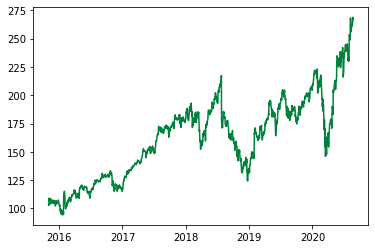

In [9]:
plt.plot(adj, color='#00823c')

In [13]:
from statsmodels.tsa.stattools import adfuller

def stationarity(timeseries):
    """
        Расчет неизменности во времени(stationarity)
        То есть, всегда есть такое же кол-во в любом варианте окна.
    """
    
    #Определяем плавующие окна (средней и отклонение)
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(50).std(ddof=0)

    #Визуализируем:
    orig = plt.plot(timeseries, color='#00823c',label='Original')
    mean = plt.plot(rolmean, color='#c00000', label='Mean')
    std = plt.plot(rolstd, color='#6db9ff', label = 'Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & STD')
    plt.show(block=False)
    
    #Тест Дикки-Фуллера
    print('Результат теста Дикки-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['open','high','Изменяемость на 10 дней', 'Плавающее среднее на 50 дней'])
    for key, value in dftest[4].items():
        dfoutput['Критическое значение (%s)'%key] = value
    print(dfoutput)
    
    
def my_stationarity(data) :   
    test = sm.tsa.adfuller(data)
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

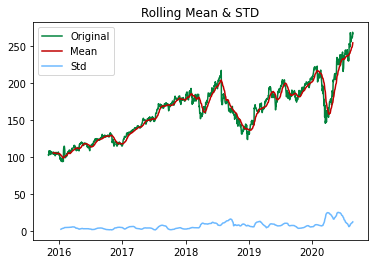

Результат теста Дикки-Фуллера:
open                              -0.799263
high                               0.819339
Изменяемость на 10 дней           21.000000
Плавающее среднее на 50 дней    1188.000000
Критическое значение (1%)         -3.435866
Критическое значение (5%)         -2.863976
Критическое значение (10%)        -2.568067
dtype: float64


In [11]:
stationarity(adj)

In [14]:
my_stationarity(adj)

adf:  -0.7992627838674333
p-value:  0.8193385233830466
Critical values:  {'1%': -3.4358664022823593, '5%': -2.8639759363158124, '10%': -2.5680669397963927}
есть единичные корни, ряд не стационарен


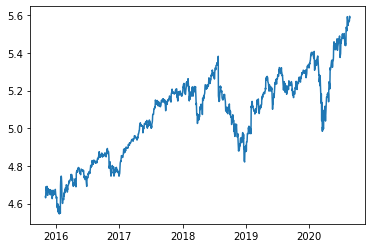

In [15]:
# логорифмирование
adj_log = np.log(adj)
plt.plot(adj_log)

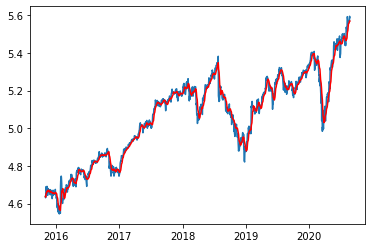

In [16]:
# сглаживание (виз для тренда)
moving_avg = adj_log.rolling(window = 10, min_periods=1).mean()
plt.plot(adj_log)
plt.plot(moving_avg, color='red')

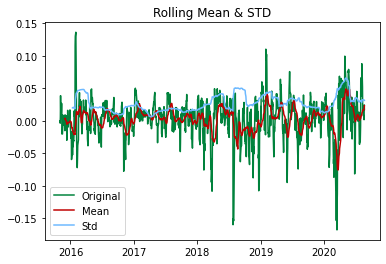

Результат теста Дикки-Фуллера:
open                           -9.375182e+00
high                            7.199326e-16
Изменяемость на 10 дней         8.000000e+00
Плавающее среднее на 50 дней    1.201000e+03
Критическое значение (1%)      -3.435807e+00
Критическое значение (5%)      -2.863950e+00
Критическое значение (10%)     -2.568053e+00
dtype: float64


In [17]:
# расчет разницы в данных
adj_log_moving_avg_diff = adj_log - moving_avg
adj_log_moving_avg_diff.dropna(inplace=True)
stationarity(adj_log_moving_avg_diff)

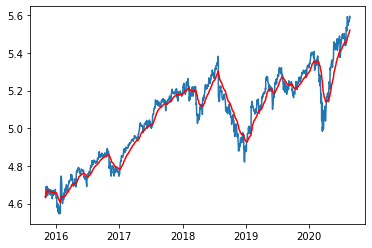

In [18]:
expwighted_avg = adj_log.ewm(halflife = 12).mean()
plt.plot(adj_log)
plt.plot(expwighted_avg, color='red')

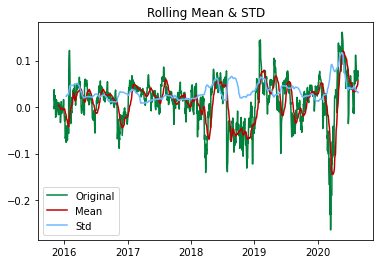

Результат теста Дикки-Фуллера:
open                              -4.852238
high                               0.000043
Изменяемость на 10 дней           10.000000
Плавающее среднее на 50 дней    1199.000000
Критическое значение (1%)         -3.435816
Критическое значение (5%)         -2.863954
Критическое значение (10%)        -2.568055
dtype: float64


In [20]:
adj_log_ewma_diff = adj_log - expwighted_avg
stationarity(adj_log_ewma_diff)

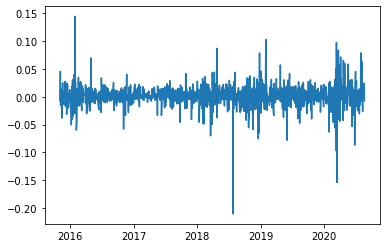

In [21]:
# делаем обзор разниц
adj_log_diff = adj_log - adj_log.shift(1)
plt.plot(adj_log_diff)

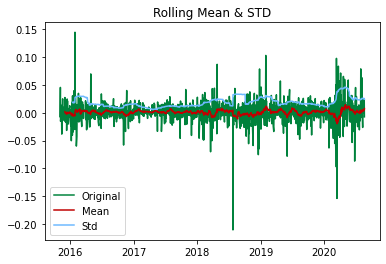

Результат теста Дикки-Фуллера:
open                           -1.228048e+01
high                            8.245381e-23
Изменяемость на 10 дней         9.000000e+00
Плавающее среднее на 50 дней    1.199000e+03
Критическое значение (1%)      -3.435816e+00
Критическое значение (5%)      -2.863954e+00
Критическое значение (10%)     -2.568055e+00
dtype: float64


In [22]:
adj_log_diff.dropna(inplace=True)
stationarity(adj_log_diff)

In [23]:
my_stationarity(adj_log_diff)

adf:  -12.280480317213536
p-value:  8.245380970241898e-23
Critical values:  {'1%': -3.4358156841149765, '5%': -2.8639535605738278, '10%': -2.568055023174024}
единичных корней нет, ряд стационарен


# Декомпозиция

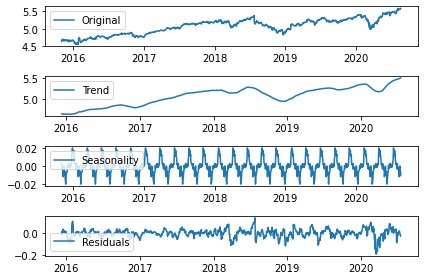

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(adj_log, freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(adj_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

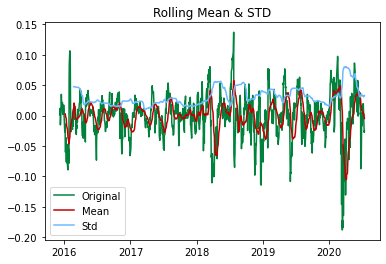

Результат теста Дикки-Фуллера:
open                           -8.137654e+00
high                            1.048625e-12
Изменяемость на 10 дней         1.200000e+01
Плавающее среднее на 50 дней    1.145000e+03
Критическое значение (1%)      -3.436074e+00
Критическое значение (5%)      -2.864068e+00
Критическое значение (10%)     -2.568116e+00
dtype: float64


In [25]:
adj_log_decompose = residual
adj_log_decompose.dropna(inplace=True)
stationarity(adj_log_decompose)

# Предикт

In [26]:
from statsmodels.tsa.arima_model import ARIMA
#ACF / PACF
from statsmodels.tsa.stattools import acf, pacf  

/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


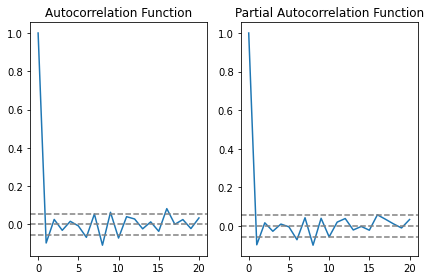

In [27]:
lag_acf = acf(adj_log_diff, nlags=20)
lag_pacf = pacf(adj_log_diff, nlags=20, method='ols')

#ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(adj_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(adj_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(adj_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(adj_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.4986')

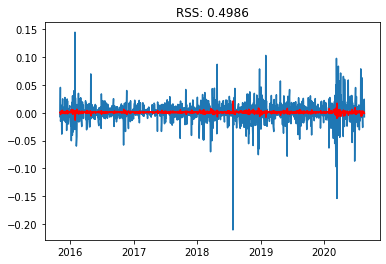

In [28]:
#MA model:
model = ARIMA(adj_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(adj_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-adj_log_diff)**2))

/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.4987')

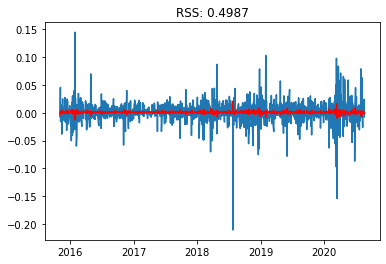

In [29]:
model = ARIMA(adj_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(adj_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-adj_log_diff)**2))

/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/lena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS (Root Squared Sum): 0.4979')

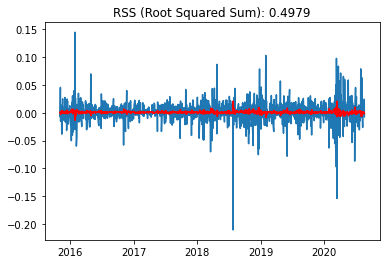

In [30]:
model = ARIMA(adj_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(adj_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS (Root Squared Sum): %.4f'% sum((results_ARIMA.fittedvalues-adj_log_diff)**2))

# Конвертация в оригинал 

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(adj_log[0], index=adj_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

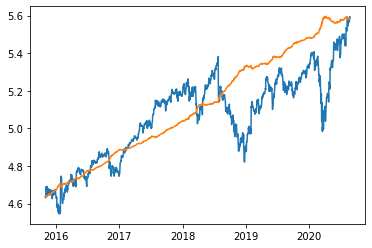

In [32]:
plt.plot(adj_log)
plt.plot(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 32.5932')

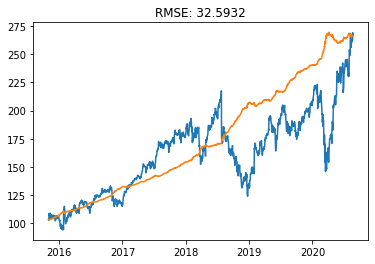

In [33]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(adj)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-adj)**2)/len(adj)))

# Делаем ML алгоритмами

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [35]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'rev_day_diff',
       '50_day_moving_avg', '10_day_volatility'],
      dtype='object')

In [87]:
df_x = data.reset_index()[['Open', 'High', 'Low','Volume','Close',
       '50_day_moving_avg', '10_day_volatility']]
df_y = data.reset_index()['Next Close']

In [101]:
df_y.shape

(1161,)

# Regression

In [96]:
reg = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2,random_state=4,shuffle=False)
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [102]:
y_predicted = reg.predict(x_test)
print(y_predicted[:5])
len(y_predicted)
len(y_test)

[190.86064343 188.95112419 187.16549943 181.02713499 181.01368577]


233

In [98]:
y_test[:5]

928    190.139999
929    189.929993
930    186.820007
931    181.279999
932    182.800003
Name: Next Close, dtype: float64

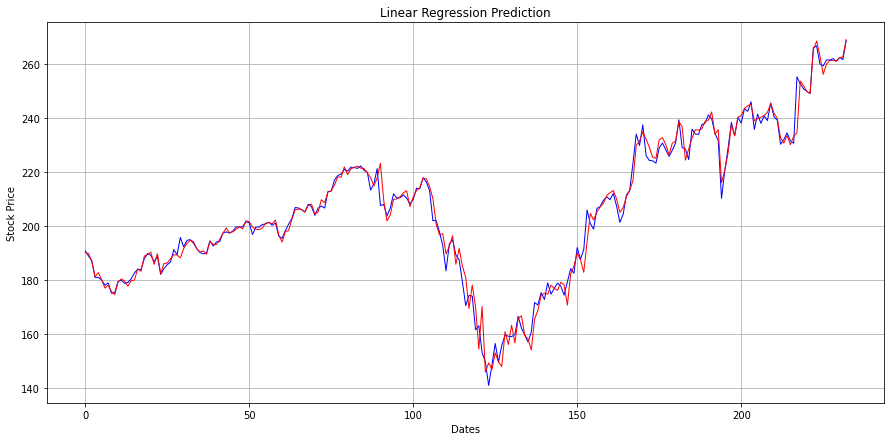

In [103]:
plt.figure(figsize=(15,7))
plt.plot(y_predicted, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

plt.title('Linear Regression Prediction')
plt.ylabel('Stock Price')
plt.xlabel('Dates')
plt.grid(True)
plt.show()

In [104]:
errors = abs (y_predicted - y_test.values)
print('Mean Absolute Error: ', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error:  2.1 degrees.


In [105]:
len(y_test)

233

In [106]:
# MAPE
mape = 100 * (errors/y_test.values)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  98.93 %.


In [116]:
df_x1 = data.reset_index()[['Open', 'High', 'Low','Volume','Close',
        '10_day_volatility']]
df_y1 = data.reset_index()['Next Close']

In [117]:
reg1 = LinearRegression()
x_train1, x_test1, y_train1, y_test1 = train_test_split(df_x1, df_y1, test_size=0.2,random_state=4,shuffle=False)
reg1.fit(x_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [119]:
y_predicted1 = reg1.predict(x_test1)

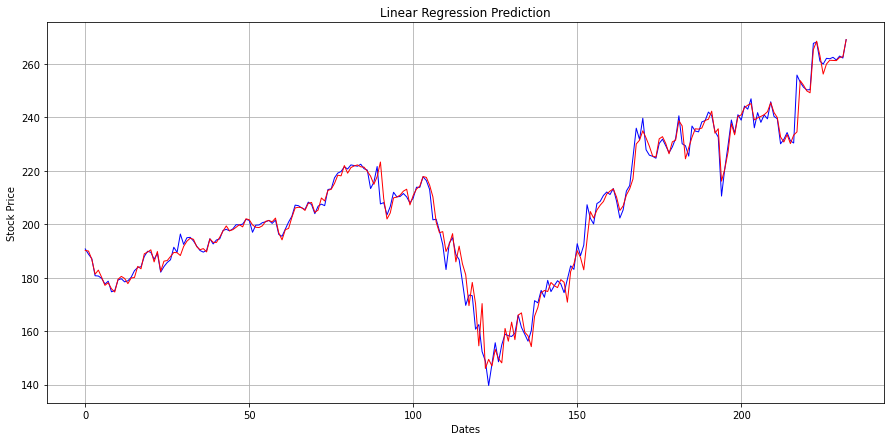

In [120]:
plt.figure(figsize=(15,7))
plt.plot(y_predicted1, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test1.values, color='red', linewidth=1, label='Actual')

plt.title('Linear Regression Prediction')
plt.ylabel('Stock Price')
plt.xlabel('Dates')
plt.grid(True)
plt.show()

In [121]:
errors1 = abs (y_predicted1 - y_test1.values)
print('Mean Absolute Error: ', round(np.mean(errors1), 2), 'degrees.')

Mean Absolute Error:  2.11 degrees.


In [122]:
# MAPE
mape1 = 100 * (errors1/y_test1.values)

accuracy1 = 100 - np.mean(mape1)
print('Accuracy: ', round(accuracy1, 2), '%.')

Accuracy:  98.92 %.


# SVR

In [107]:
clf = SVR(kernel='rbf', C=1e3, gamma=0.1)
clf.fit(x_train, y_train) 
predictions = clf.predict(x_test)

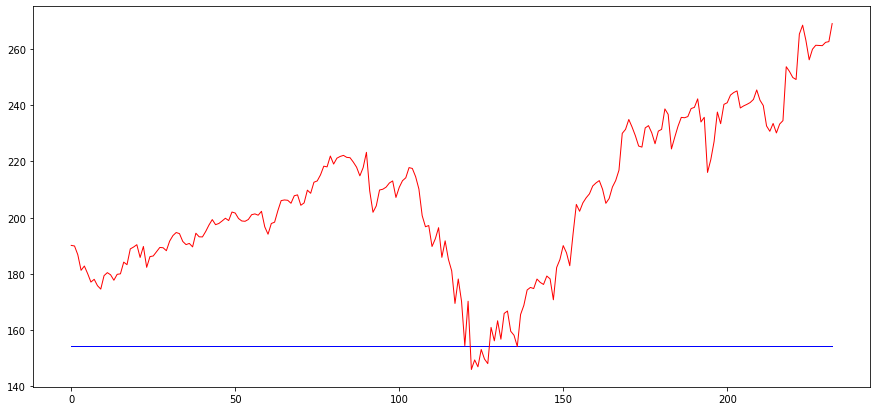

In [108]:
plt.figure(figsize=(15,7))
plt.plot(predictions, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

In [109]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  75.93 %.


# Decision Tree Regression

In [110]:
regressor = DecisionTreeRegressor(max_depth=10)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)

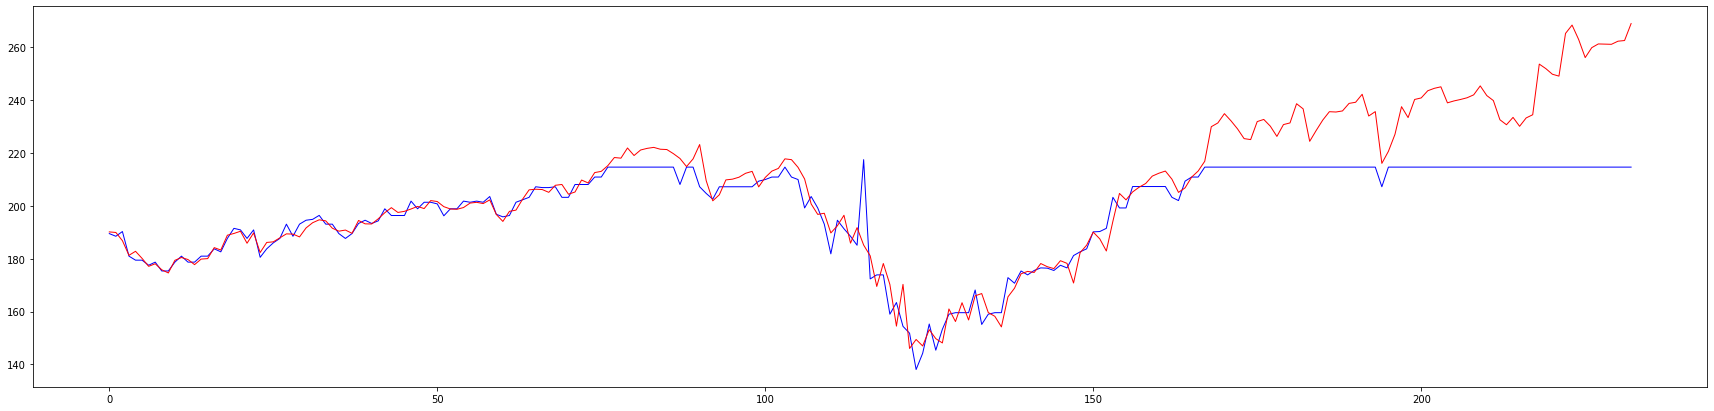

In [111]:
plt.figure(figsize=(30,7))
plt.plot(predictions, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

In [112]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  95.86 %.


# Regression Forest

In [113]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0)
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)

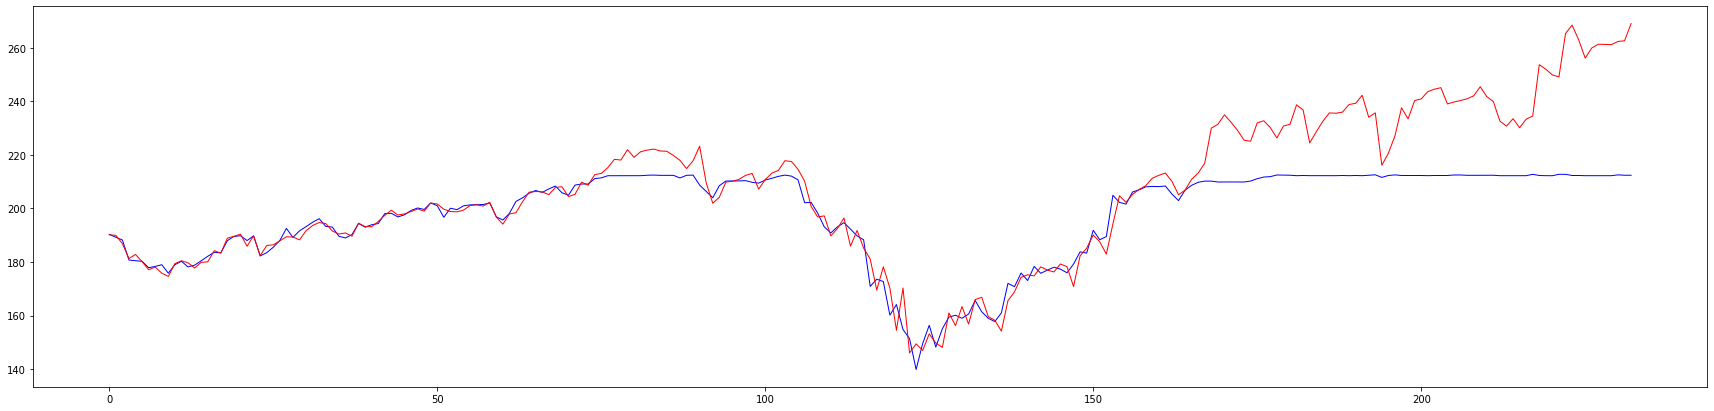

In [114]:
plt.figure(figsize=(30, 7))
plt.plot(predictions, color='blue', linewidth=1, label='Predicted')
plt.plot(y_test.values, color='red', linewidth=1, label='Actual')

In [115]:
errors = abs(predictions - y_test.values)
mape = 100 * (errors/y_test.values)
accuracy = 100 - np.mean(mape)
print('Accuracy: ', round(accuracy, 2), '%.')

Accuracy:  95.74 %.
